In [1]:
!pip install -U datasets transformers accelerate bitsandbytes trl peft evaluate codebleu[all]
from datasets import load_dataset
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer,AutoModelForCausalLM,BitsAndBytesConfig,TrainingArguments,DataCollatorWithPadding
from peft import LoraConfig, PeftModel,prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from transformers import pipeline
from datasets import Dataset
from codebleu import calc_codebleu
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.6/542.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from huggingface_hub import notebook_login
notebook_login()

# **FINE TUNING Llama3.2 for react prompts**


This can achevied in following steps:

1.DOWNLOAD hugging face format llama2 model from Hugging face and tokenizer into colab

2.Preprocess the data to training format

3.Load model into RAM by quantizing using bitsandbytes and configure the LORA parameters

4.Finetune the model using LORA technique from peft with sfttrainer



# **PREPROCESING THE DATA**

In [4]:
pd.set_option('display.max_colwidth', 1000)
df=pd.read_json("/content/react.json")
df.sample(5)

,0
46,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', arg..."
106,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', arg..."
34,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', arg..."
111,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string param

In [5]:
react=[]
for i in df.values:
     react.append(i[0])

In [6]:
df_r=pd.DataFrame(react,index=None,columns=["react"])

In [7]:
df_r

,react
0,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', arg..."
1,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', arg..."
2,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', arg..."
3,"Answer the following questions as best as you can. You have access to the following tools:\n [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string paramet

In [8]:
llama3_2="meta-llama/Llama-3.2-1B-Instruct"

finetuned_n="finetuned/Llama-3.2-1B-Instruct-react"

In [9]:
dataset=Dataset.from_pandas(df_r)

tokenizer=AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")


dataset_split = dataset.train_test_split(test_size=0.02)
train_data = dataset_split["train"]
validation_data = dataset_split["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [10]:
train_data

Dataset({
    features: ['react'],
    num_rows: 113
})

# **Load model by quantizing**

In [11]:
bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False
    )

model=AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct",quantization_config=bnb_config,device_map="auto")


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

 **Since it is a base model which is not trained upon code datasets it will** **hallucinate which can be seen below with the above example**

# **Configuring the LORA model**

In [12]:
lora_config=LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj","down_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = prepare_model_for_kbit_training(model)

model_r = get_peft_model(model, lora_config)

model_r.config.use_cache = False
model_r.config.pretraining_tp = 1

trainable, total = model_r.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.2f}%")
print(f'Memory used by model: {round(model_r.get_memory_footprint()/2**30, 2)} GB')

Trainable: 2818048 | total: 1238632448 | Percentage: 0.23%
Memory used by model: 1.44 GB


In [ ]:
print(model_r) #details of the QLORA model of llama

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit

# **Preparing the model for training**

In [13]:
from transformers import DataCollatorWithPadding,Trainer,DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False)

training_arguments = TrainingArguments(
    output_dir="/content/output",
    num_train_epochs=3,
    report_to="none",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing = True,
    optim="paged_adamw_32bit",
    save_steps=25,
    eval_steps=1,
    logging_steps=1,
    learning_rate=2e-3,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=1,
    warmup_ratio=0.03,
    evaluation_strategy="steps",
    group_by_length=True,
    lr_scheduler_type="cosine"

)


trainer = SFTTrainer(
    model=model_r,
    train_dataset=train_data,
    eval_dataset=validation_data,
    dataset_text_field="react",
    max_seq_length=512,
    args=training_arguments,
    tokenizer=tokenizer,
    data_collator=data_collator,
    packing=True

)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, packing. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:212: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will o

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Step,Training Loss,Validation Loss
1,2.623000,2.597133
2,2.548700,1.799000
3,1.855400,1.074480
4,1.085700,1.064213
5,1.081300,0.578990
6,0.571000,0.464251
7,0.449400,0.364300
8,0.365600,0.319453
9,0.357000,0.293576
10,0.280700,0.283136


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=15, training_loss=0.8245588093996048, metrics={'train_runtime': 282.0813, 'train_samples_per_second': 0.83, 'train_steps_per_second': 0.053, 'total_flos': 701569884487680.0, 'train_loss': 0.8245588093996048, 'epoch': 3.0})

In [14]:
trainer.model.save_pretrained(finetuned_n)

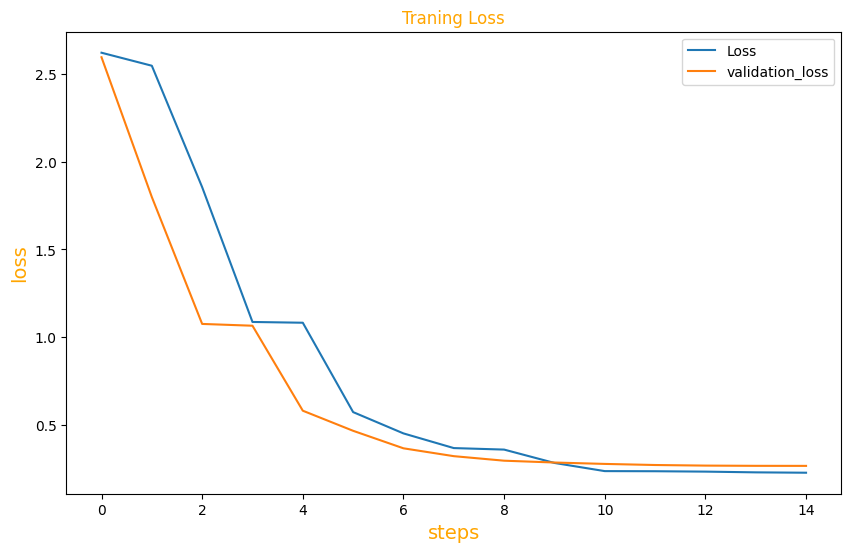

In [15]:
import matplotlib.pyplot as plt
loss=pd.DataFrame(trainer.state.log_history[0::2])
val_loss=pd.DataFrame(trainer.state.log_history[1::2])
history=pd.concat([loss,val_loss],axis=1)
history=history[['loss','eval_loss']]

fig,axis = plt.subplots(1,1,figsize=(10,6))
axis.plot(history)
axis.set_title("Traning Loss",c="orange")
axis.set_xlabel("steps", fontsize=14, c="orange")
axis.set_ylabel("loss", fontsize=14,c="orange")
axis.legend(["Loss","validation_loss"], loc="best")
plt.show()


# **Checking the Finetuned Model**

In [16]:
base_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
peft_model_id = "finetuned/Llama-3.2-1B-Instruct-react"
model_rf = PeftModel.from_pretrained(base_model, peft_model_id)
merged_model = model_rf.merge_and_unload()


In [17]:
merged_model.save_pretrained("final_model/Llama-3.2-1B-Instruct-react-finetuned")

In [26]:
def inference(prompt):
    device = "cuda:0"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model_r.generate(**inputs, max_new_tokens=512).to(device)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [28]:
prompt="""Answer the following questions as best as you can. You have access to the following tools:
 [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', args_schema=<class 'langchain_core.utils.pydantic.retriever'>, func=<function retriever at 0x7abfc1345240>)]

 Use the following format:


 """

In [29]:
print(inference(prompt))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Answer the following questions as best as you can. You have access to the following tools:
 [Tool(name='Wikipedia', description='Use for in-depth topic exploration with detailed, user-curated articles and references.', func=<bound method WikipediaAPIWrapper.run of WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.10/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)>), Tool(name='search', description=' Use for general topic searches, aggregating results from multiple sources. Simply input a search query to get started.', func=<bound method BaseTool.run of DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='api', source='text'))>), StructuredTool(name='retriever', description='This function retrieves information stored in the database related to LangChain. It takes a string parameter as input.', args_sch

In [36]:
merged_model.push_to_hub("Llama-3.2-1B-Instruct-react-finetuned")
tokenizer.push_to_hub("Llama-3.2-1B-Instruct-react-finetuned")

model.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kalyan99/Llama-3.2-1B-Instruct-react-finetuned/commit/e2041b89ff262ffced095c661c1b81f7622c2e42', commit_message='Upload tokenizer', commit_description='', oid='e2041b89ff262ffced095c661c1b81f7622c2e42', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kalyan99/Llama-3.2-1B-Instruct-react-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='kalyan99/Llama-3.2-1B-Instruct-react-finetuned'), pr_revision=None, pr_num=None)

##THE END